In [5]:
# %pip install sentence_transformers usearch

In [43]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from usearch.index import Index

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [1]:
db_path = "../../../data/basnya.db"
sql_query = """
    SELECT bs.*--, g.*
    FROM boxscoretraditionalv2_0 as bs
    LEFT JOIN GAMES as g
        ON bs.GAME_ID_STR = g.GAME_ID_STR
    WHERE g.season_type == 2 and g.SEASON > 2020
    --LIMIT 5
    """
with sqlite3.connect(db_path) as connection:
    df = pd.read_sql(sql_query, connection)
print(df.shape)
df.drop_duplicates(subset=['GAME_ID', 'PLAYER_ID'], inplace=True)
df.dropna(subset=['MIN'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(70660, 31)
(58195, 31)


,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR
0,102747,22100001,1610612749,MIL,Milwaukee,201572,Brook Lopez,Brook,C,None,...,3.0,5.0,0.0,1.0,3.0,0.0,3.0,8.0,0.0,0022100001
1,102751,22100001,1610612749,MIL,Milwaukee,201588,George Hill,George,None,None,...,3.0,5.0,3.0,0.0,1.0,1.0,5.0,1.0,-6.0,0022100001
2,102749,22100001,1610612749,MIL,Milwaukee,201950,Jrue Holiday,Jrue,G,None,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,17.0,0022100001
3,102745,22100001,1610612749,MIL,Milwaukee,203114,Khris Middleton,Khris,F,None,...,9.0,9.0,3.0,1.0,0.0,1.0,3.0,20.0,20.0,0022100001
4,102746,22100001,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,Giannis,F,None,...,9.0,14.0,7.0,1.0,2.0,4.0,4.0,32.0,25.0,0022100001


In [2]:
COLS_TO_EMBED = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
                 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'] 
COL_TO_NAME = {
'MIN': 'Minutes played',
'FGM': 'Field goals made',
'FGA': 'Field goals attempted',
'FG3M': 'Three-pointers made',
'FG3A': 'Three-pointers attempted',
'FTM': 'Free throws made',
'FTA': 'Free throws attempted',
'REB': 'Total rebounds',
'AST': 'Assists',
'STL': 'Steals',
'BLK': 'Blocks',
'TO': 'Turnovers',
'PF': 'Personal fouls',
'PTS': 'Points scored',
'PLUS_MINUS': 'Point differential',
}
def prepare_text(row):
    def _val(c):
        return row[c] if c == 'MIN' else int(row[c])
            
    return " | ".join([f"{COL_TO_NAME[col]} = {_val(col)}" for col in COLS_TO_EMBED])

print(prepare_text(df.iloc[0]))

df['txt'] = df.apply(prepare_text, axis=1)

df.txt.map(len).value_counts(dropna=False)

Minutes played = 28.000000:10 | Field goals made = 3 | Field goals attempted = 9 | Three-pointers made = 2 | Three-pointers attempted = 4 | Free throws made = 0 | Free throws attempted = 0 | Total rebounds = 5 | Assists = 0 | Steals = 1 | Blocks = 3 | Turnovers = 0 | Personal fouls = 3 | Points scored = 8 | Point differential = 0


332    12635
333    12408
331    10273
334     9462
335     6372
330     3780
336     2276
337      707
338      238
339       44
Name: txt, dtype: int64

In [5]:
model = SentenceTransformer('thenlper/gte-base', device='cpu')

_emb768 = model.encode(df.txt.tolist(), show_progress_bar=True, device='cpu') 
_emb768.shape

Batches:   0%|          | 0/1819 [00:00<?, ?it/s]

(58195, 768)

In [8]:
df['emb768'] = list(_emb768)
print(df.emb768.iloc[42].shape)
df.head(2)

(768,)


,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR,txt,emb768
0,102747,22100001,1610612749,MIL,Milwaukee,201572,Brook Lopez,Brook,C,None,...,0.0,1.0,3.0,0.0,3.0,8.0,0.0,0022100001,Minutes played = 28.000000:10 | Field goals ma...,"[-0.0015627241, -0.00506972, 0.001668589, -0.0..."
1,102751,22100001,1610612749,MIL,Milwaukee,201588,George Hill,George,None,None,...,3.0,0.0,1.0,1.0,5.0,1.0,-6.0,0022100001,Minutes played = 23.000000:21 | Field goals ma...,"[-2.575098e-05, 0.003177214, -0.004548328, -0...."


In [9]:
df.to_pickle('boxscore_and_embeddings.pkl.zip', compression='zip')
!du -hs *.zip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
161M	boxscore_and_embeddings.pkl.zip


In [16]:
%%time
index = Index(ndim=df.emb768.iloc[0].shape[0])

_inserted = index.add(df.index.values, _emb768)
_inserted.shape

CPU times: user 1min 34s, sys: 179 ms, total: 1min 34s
Wall time: 6.06 s


(58195,)

In [48]:
sql_query_search = """
    SELECT bs.*--, g.*
    FROM boxscoretraditionalv2_0 as bs
    LEFT JOIN GAMES as g
        ON bs.GAME_ID_STR = g.GAME_ID_STR
    WHERE g.season_type == 2 and PTS >= 61 and g.SEASON <= 2020
    --LIMIT 5
    """
with sqlite3.connect(db_path) as connection:
    df_search = pd.read_sql(sql_query_search, connection)
print(df_search.shape)
df_search.drop_duplicates(subset=['GAME_ID', 'PLAYER_ID'], inplace=True)
df_search.dropna(subset=['MIN'], inplace=True)
df_search.reset_index(drop=True, inplace=True)
print(df_search.shape)

df_search['txt'] = df_search.apply(prepare_text, axis=1)
_emb768_search = model.encode(df_search.txt.tolist(), show_progress_bar=True, device='cpu') 
df_search['emb768'] = list(_emb768_search)
df_search.head()

(5, 31)
(5, 31)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR,txt,emb768
0,34321,21800710,1610612745,HOU,Houston,201935,James Harden,James,G,None,40.000000:00,17.0,38.0,0.447,5.0,20.0,0.250,22.0,25.0,0.880,6.0,9.0,15.0,4.0,5.0,0.0,5.0,3.0,61.0,19.0,0021800710,Minutes played = 40.000000:00 | Field goals ma...,"[0.010690313, -0.006593872, 7.716201e-05, -0.0..."
1,43662,21801084,1610612745,HOU,Houston,201935,James Harden,James,G,None,36.000000:40,19.0,34.0,0.559,9.0,13.0,0.692,14.0,17.0,0.824,2.0,5.0,7.0,1.0,3.0,0.0,3.0,3.0,61.0,18.0,0021801084,Minutes played = 36.000000:40 | Field goals ma...,"[0.002506695, -0.000970756, 0.0027286883, -0.0..."
2,63656,21900652,1610612757,POR,Portland,203081,Damian Lillard,Damian,G,None,45.000000:08,17.0,37.0,0.459,11.0,20.0,0.550,16.0,16.0,1.000,0.0,10.0,10.0,7.0,1.0,0.0,2.0,1.0,61.0,13.0,0021900652,Minutes played = 45.000000:08 | Field goals ma...,"[0.005416558, -0.00014519395, 0.0029695847, -0..."
3,73392,21901300,1610612757,POR,Portland,203081,Damian Lillard,Damian,G,None,41.000000:05,17.0,32.0,0.531,9.0,17.0,0.529,18.0,18.0,1.000,2.0,3.0,5.0,8.0,1.0,0.0,3.0,2.0,61.0,8.0,0021901300,Minutes played = 41.000000:05 | Field goals ma...,"[0.0028391136, 0.0005283239, 0.0029787875, -0...."
4,76393,22000092,1610612744,GSW,Golden State,201939,Stephen Curry,Stephen,G,None,36.000000:26,18.0,31.0,0.581,8.0,16.0,0.500,18.0,19.0,0.947,1.0,4.0,5.0,4.0,0.0,0.0,5.0,0.0,62.0,20.0,0022000092,Minutes played = 36.000000:26 | Field goals ma...,"[0.0038845525, -0.0016157319, 0.002392998, -0...."


In [56]:
matches = index.search(_emb768_search, count=5)
df.loc[np.unique(matches.keys)]

,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR,txt,emb768,cluster,_min,_sec,min_sec
274,103065,22100013,1610612758,SAC,Sacramento,203084,Harrison Barnes,Harrison,F,None,36.000000:54,10.0,19.0,0.526,8.0,11.0,0.727,8.0,9.0,0.889,2.0,7.0,9.0,2.0,2.0,0.0,0.0,0.0,36.0,6.0,0022100013,Minutes played = 36.000000:54 | Field goals ma...,"[0.003568992, -0.0020236997, 0.0025805642, -0....",6,36.000000,54,36.900000
2534,105862,22100116,1610612742,DAL,Dallas,1628973,Jalen Brunson,Jalen,G,None,36.000000:25,9.0,17.0,0.529,1.0,4.0,0.250,12.0,15.0,0.800,1.0,9.0,10.0,3.0,2.0,0.0,2.0,2.0,31.0,13.0,0022100116,Minutes played = 36.000000:25 | Field goals ma...,"[0.004118567, -0.0013195083, 0.0030054029, -0....",6,36.000000,25,36.416667
13784,119339,22100642,1610612757,POR,Portland,1629014,Anfernee Simons,Anfernee,G,None,40.000000:22,11.0,21.0,0.524,7.0,14.0,0.500,2.0,3.0,0.667,0.0,0.0,0.0,11.0,2.0,0.0,2.0,0.0,31.0,13.0,0022100642,Minutes played = 40.000000:22 | Field goals ma...,"[0.00583352, 0.00010744877, 0.0014778483, -0.0...",0,40.000000,22,40.366667
16249,122321,22100759,1610612739,CLE,Cleveland,201567,Kevin Love,Kevin,None,None,33.000000:01,6.0,15.0,0.400,3.0,8.0,0.375,0.0,0.0,0.000,1.0,10.0,11.0,3.0,0.0,2.0,0.0,1.0,15.0,17.0,0022100759,Minutes played = 33.000000:01 | Field goals ma...,"[0.0071644387, -0.010179208, -0.00042301536, -...",9,33.000000,01,33.016667
20617,127540,22100969,1610612755,PHI,Philadelphia,203954,Joel Embiid,Joel,C,None,36.000000:19,15.0,27.0,0.556,1.0,3.0,0.333,12.0,16.0,0.750,3.0,11.0,14.0,2.0,2.0,3.0,2.0,2.0,43.0,14.0,0022100969,Minutes played = 36.000000:19 | Field goals ma...,"[0.0009221872, -0.0025706654, 0.0028616241, -0...",1,36.000000,19,36.316667
25079,132898,22101185,1610612760,OKC,Oklahoma City,1629658,Jaylen Hoard,Jaylen,F,None,45.000000:35,11.0,17.0,0.647,1.0,3.0,0.333,1.0,6.0,0.167,7.0,14.0,21.0,3.0,3.0,0.0,2.0,2.0,24.0,9.0,0022101185,Minutes played = 45.000000:35 | Field goals ma...,"[0.00735308, 0.0014679591, 0.0023512254, -0.01...",6,45.000000,35,45.583333
28908,137528,22200131,1610612762,UTA,Utah,1628374,Lauri Markkanen,Lauri,F,None,32.000000:42,9.0,17.0,0.529,3.0,9.0,0.333,6.0,6.0,1.000,3.0,10.0,13.0,4.0,1.0,1.0,1.0,1.0,27.0,4.0,0022200131,Minutes played = 32.000000:42 | Field goals ma...,"[0.003342554, -0.000535939, 0.0034279486, -0.0...",0,32.000000,42,32.700000
35718,145663,22200454,1610612737,ATL,Atlanta,1629027,Trae Young,Trae,G,None,36.000000:17,11.0,22.0,0.500,3.0,7.0,0.429,12.0,12.0,1.000,1.0,2.0,3.0,13.0,0.0,0.0,4.0,1.0,37.0,4.0,0022200454,Minutes played = 36.000000:17 | Field goals ma...,"[0.0040998254, -0.00080247823, 0.0050317934, -...",6,36.000000,17,36.283333
35792,145723,22200457,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,Giannis,F,None,33.000000:58,12.0,17.0,0.706,1.0,3.0,0.333,17.0,22.0,0.773,1.0,9.0,10.0,1.0,0.0,1.0,2.0,4.0,42.0,1.0,0022200457,Minutes played = 33.000000:58 | Field goals ma...,"[0.003577654, -0.0023983698, 0.004740272, -0.0...",6,33.000000,58,33.966667
35799,145752,22200458,1610612757,POR,Portland,203081,Damian Lillard,Damian,G,None,39.000000:00,9.0,17.0,0.529,6.0,12.0,0.500,4.0,4.0,1.000,0.0,3.0,3.0,6.0,1.0,0.0,4.0,4.0,28.0,0.0,0022200458,Minutes played = 39.000000:00 | Field goals ma...,"[0.008316327, -0.008711646, 0.0048297434, -0.0...",9,39.000000,00,39.000000


In [58]:
matches = index.search(_emb768[:1], count=3)
df.loc[np.unique(matches.keys)]

,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR,txt,emb768,cluster,_min,_sec,min_sec
0,102747,22100001,1610612749,MIL,Milwaukee,201572,Brook Lopez,Brook,C,None,28.000000:10,3.0,9.0,0.333,2.0,4.0,0.5,0.0,0.0,0.0,2.0,3.0,5.0,0.0,1.0,3.0,0.0,3.0,8.0,0.0,0022100001,Minutes played = 28.000000:10 | Field goals ma...,"[-0.0015627241, -0.00506972, 0.001668589, -0.0...",1,28.000000,10,28.166667
14759,120538,22100689,1610612764,WAS,Washington,203484,Kentavious Caldwell-Pope,Kentavious,F,None,28.000000:10,4.0,8.0,0.500,2.0,5.0,0.4,0.0,0.0,0.0,0.0,3.0,3.0,5.0,1.0,0.0,2.0,0.0,10.0,9.0,0022100689,Minutes played = 28.000000:10 | Field goals ma...,"[-0.00043194235, -0.006143507, 0.00037346664, ...",1,28.000000,10,28.166667
44390,156332,22200871,1610612746,LAC,LA,1627826,Ivica Zubac,Ivica,C,None,28.000000:10,5.0,9.0,0.556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,1.0,1.0,3.0,10.0,8.0,0022200871,Minutes played = 28.000000:10 | Field goals ma...,"[-1.3053987e-05, -0.005257876, 0.0003768594, -...",1,28.000000,10,28.166667


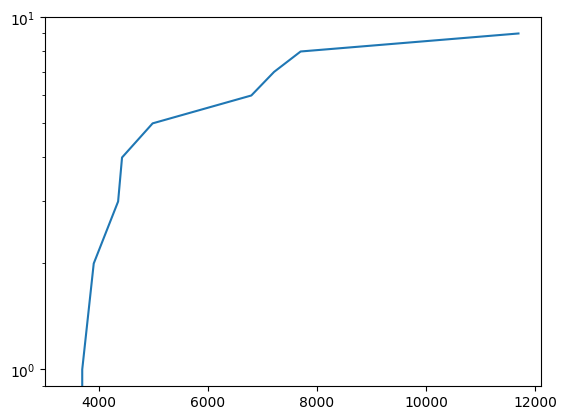

In [20]:
clustering = index.cluster(min_count=5, max_count=10)

# Get the clusters and their sizes
centroid_keys, sizes = clustering.centroids_popularity

# Use Matplotlib to draw a histogram
clustering.plot_centroids_popularity()

In [24]:
df[['_min', '_sec']] = df['MIN'].str.split(':', expand=True)
df['min_sec'] = df._min.astype(float) + df._sec.astype(int) / 60 

In [29]:
for i, key in enumerate(centroid_keys):
    _idx = clustering.members_of(key)
    df.loc[_idx, 'cluster'] = i
df.cluster = df.cluster.astype(int)
df.cluster.value_counts(dropna=False)

9    11695
0     7700
1     7213
8     6796
5     4986
6     4425
7     4353
3     3906
2     3695
4     3426
Name: cluster, dtype: int64

<Axes: xlabel='PTS', ylabel='min_sec'>

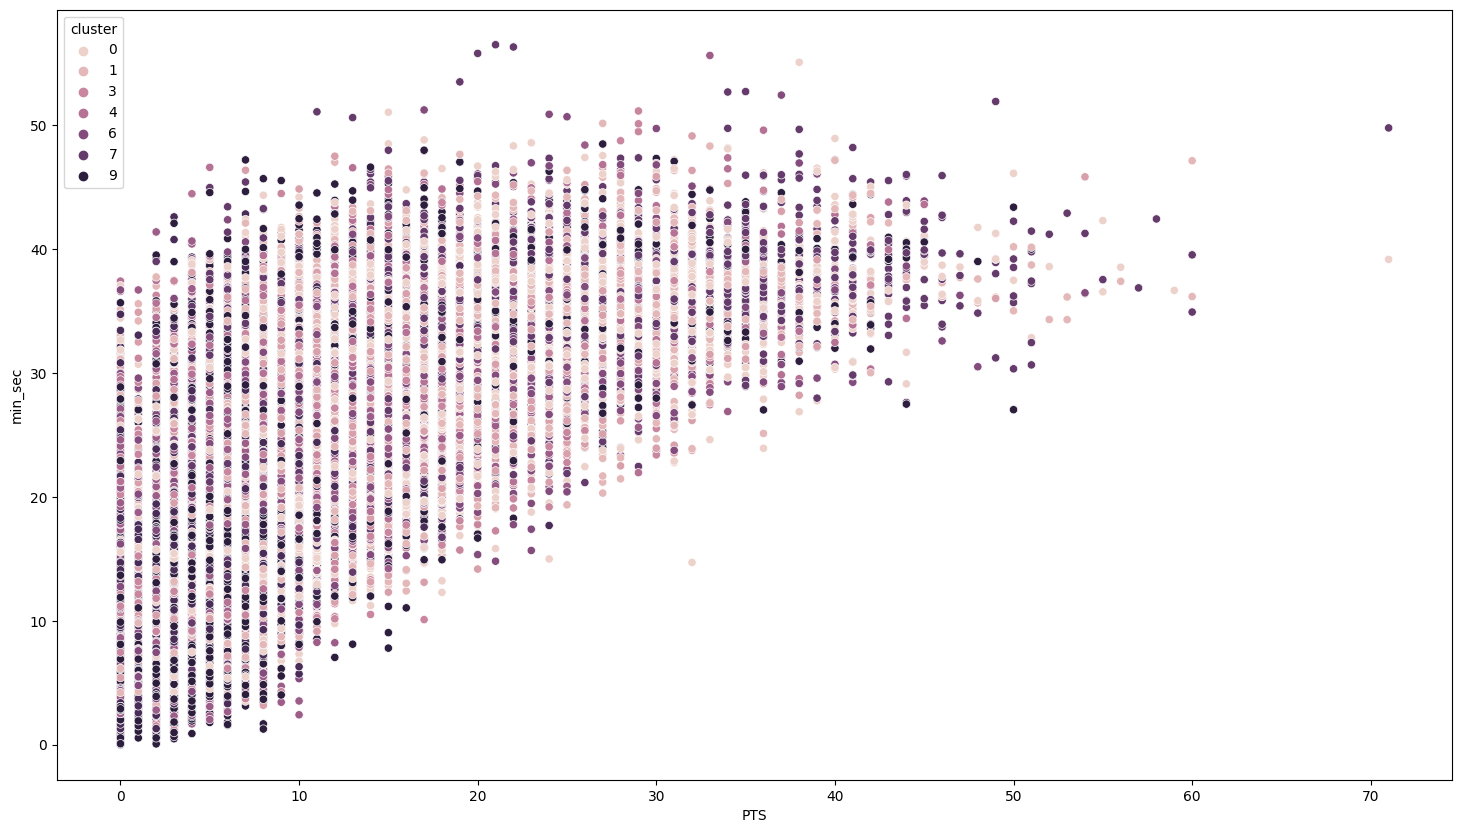

In [38]:
plt.figure(figsize=(18,10))
sns.scatterplot(data=df, x='PTS', y='min_sec', hue='cluster')

<Axes: xlabel='cluster', ylabel='PTS'>

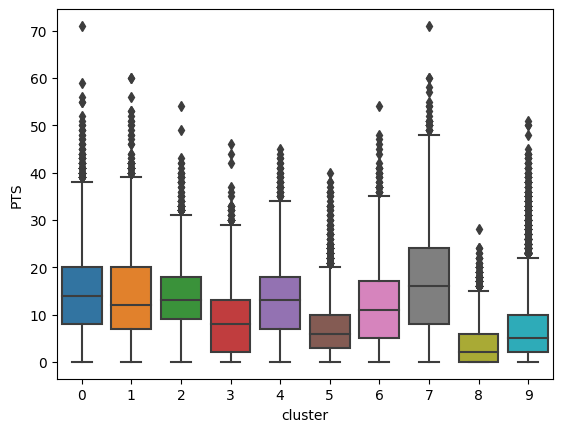

In [36]:
sns.boxplot(data=df, y='PTS', x='cluster')

In [40]:
def find_outliers(embeddings):
    lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.02)  # Adjust parameters as needed
    outlier_scores = lof_model.fit_predict(embeddings)
    outliers = np.where(outlier_scores == -1)[0]
    return outliers

outliers_indices = find_outliers(_emb768)
print(outliers_indices.shape)

(1164,)


In [44]:
df.loc[outliers_indices[:5]]

,index,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_ID_STR,txt,emb768,cluster,_min,_sec,min_sec
41,102773,22100002,1610612747,LAL,Los Angeles,201566,Russell Westbrook,Russell,G,None,35.000000:08,4.0,13.0,0.308,0.0,4.0,0.000,0.0,0.0,0.000,1.0,4.0,5.0,4.0,0.0,0.0,4.0,4.0,8.0,-23.0,0022100002,Minutes played = 35.000000:08 | Field goals ma...,"[0.003021044, 0.0012911777, 0.003969358, -0.01...",1,35.000000,08,35.133333
97,102853,22100005,1610612752,NYK,New York,203944,Julius Randle,Julius,F,None,45.000000:59,12.0,27.0,0.444,3.0,8.0,0.375,8.0,8.0,1.000,0.0,8.0,8.0,9.0,0.0,3.0,7.0,4.0,35.0,10.0,0022100005,Minutes played = 45.000000:59 | Field goals ma...,"[0.0010306002, 0.0013256711, -0.0058810883, -0...",7,45.000000,59,45.983333
99,102852,22100005,1610612752,NYK,New York,1629628,RJ Barrett,RJ,F,None,47.000000:03,6.0,11.0,0.545,3.0,7.0,0.429,4.0,6.0,0.667,0.0,5.0,5.0,2.0,0.0,2.0,0.0,5.0,19.0,8.0,0022100005,Minutes played = 47.000000:03 | Field goals ma...,"[0.0033889704, 0.003678241, -0.0031213239, -0....",7,47.000000,03,47.050000
116,102866,22100006,1610612764,WAS,Washington,203484,Kentavious Caldwell-Pope,Kentavious,F,None,27.000000:08,2.0,7.0,0.286,1.0,5.0,0.200,0.0,0.0,0.000,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,5.0,2.0,0022100006,Minutes played = 27.000000:08 | Field goals ma...,"[0.003757908, -0.0022020384, 0.0043879687, -0....",1,27.000000,08,27.133333
170,102971,22100009,1610612740,NOP,New Orleans,202066,Garrett Temple,Garrett,None,None,15.000000:06,0.0,1.0,0.000,0.0,1.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-17.0,0022100009,Minutes played = 15.000000:06 | Field goals ma...,"[0.0062010284, 0.0030575513, 0.007809864, -0.0...",7,15.000000,06,15.100000
